# Elliptic AML Dataset Exploration
Initial exploration and visualization of the dataset.

###  Workflow Overview

This notebook performs the following steps:

1. Load and inspect raw CSV files from the Elliptic dataset
2. Construct a transaction graph using NetworkX
3. Calculate key graph metrics (e.g., PageRank, Degree)
4. Identify the largest connected component (LCC)
5. Visualize graph structure
6. Prepare for merging features and labels for classification



### Extract zip file

In [2]:
import zipfile, os, pathlib

RAW_DIR = pathlib.Path("../data/raw")
DATA_DIR = pathlib.Path("../data/elliptic_bitcoin_dataset")
ZIP_PATH = RAW_DIR / "archive.zip"   # Adjust if your zip file has another name

def extracted_ok(data_dir: pathlib.Path):
    return data_dir.exists() and all(
        (data_dir / fname).exists() for fname in [
            "elliptic_txs_features.csv",
            "elliptic_txs_edgelist.csv",
            "elliptic_txs_classes.csv",
        ]
    )

if not extracted_ok(DATA_DIR):
    if ZIP_PATH.exists():
        DATA_DIR.parent.mkdir(parents=True, exist_ok=True)
        with zipfile.ZipFile(ZIP_PATH, "r") as z:
            z.extractall(DATA_DIR.parent)  
        print("✅ Dataset extracted.")
    else:
        print(f"❌ Zip not found: {ZIP_PATH}")
else:
    print("✅ Dataset already extracted at:", DATA_DIR)


✅ Dataset extracted.


### Loading the Dataset

We load the three core CSV files: node features, edge list, and class labels.

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

features_df = pd.read_csv(DATA_DIR / "elliptic_txs_features.csv", header=None)
edges_df    = pd.read_csv(DATA_DIR / "elliptic_txs_edgelist.csv")
classes_df  = pd.read_csv(DATA_DIR / "elliptic_txs_classes.csv")

###  Exploring Dataset Shapes and Missing Values

Let’s inspect the number of rows and columns in each dataset and identify any missing values.

In [4]:
# Sanity checks
assert len(features_df) == len(classes_df), "Mismatch: features vs classes rows"
assert classes_df["txId"].is_unique, "Duplicate txId in classes"

edge_nodes = set(edges_df["txId1"]).union(set(edges_df["txId2"]))
class_nodes = set(classes_df["txId"])
missing_in_class = edge_nodes - class_nodes
assert len(missing_in_class) == 0, f"{len(missing_in_class)} edge nodes not found in classes"

print("Features shape:", features_df.shape)
print("Edges shape:", edges_df.shape)
print("Classes shape:", classes_df.shape)
print("Missing values in features:", features_df.isna().sum().sum())

Features shape: (203769, 167)
Edges shape: (234355, 2)
Classes shape: (203769, 2)
Missing values in features: 0


### Visualizing Class Distribution

We plot how many transactions are labeled as illicit, licit, or unknown.

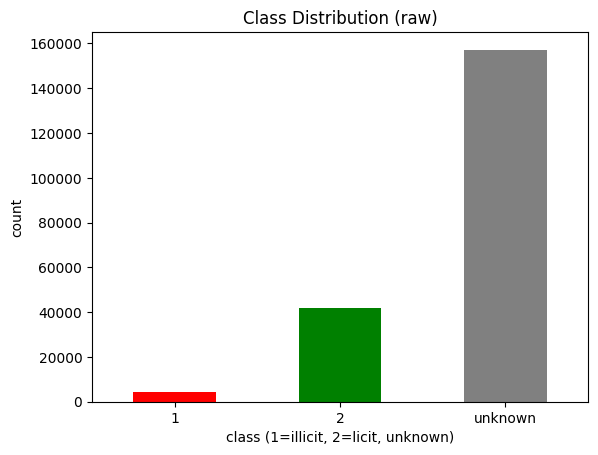

Supervised subset size: 46564 / 203769
Supervised label counts: {0.0: 42019, 1.0: 4545}


In [5]:
ax = classes_df["class"].value_counts().reindex(["1","2","unknown"]).fillna(0).plot(
    kind="bar", color=["red","green","gray"]
)
plt.title("Class Distribution (raw)")
plt.xticks(rotation=0)
plt.xlabel("class (1=illicit, 2=licit, unknown)")
plt.ylabel("count")
plt.show()

# Supervised subset: drop 'unknown' and map illicit=1, licit=0
label_map = {"1":1, "2":0, 1:1, 2:0}
y_raw = classes_df["class"].map(label_map)
mask_supervised = y_raw.notna()
print("Supervised subset size:", mask_supervised.sum(), "/", len(y_raw))
print("Supervised label counts:", y_raw[mask_supervised].value_counts().to_dict())


### Class Distribution

- The majority of transactions (~158k) are labeled as **unknown**.
- Legitimate (class 2) transactions are around ~42k, while illicit (class 1) transactions are only ~4k.
- This is a **heavily imbalanced classification problem**, common in fraud detection.
- We will need to consider strategies like class weights or oversampling later.

### Constructing and Inspecting the Transaction Graph

We use NetworkX to construct a graph and inspect its basic statistics.

In [6]:
G = nx.from_pandas_edgelist(edges_df, "txId1", "txId2")

print("✅ Graph Summary:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed?: {G.is_directed()}")
print(f"Number of connected components: {nx.number_connected_components(G)}")


✅ Graph Summary:
Number of nodes: 203769
Number of edges: 234355
Is directed?: False
Number of connected components: 49


### Transaction Graph Structure

- Total nodes: `203,769`, Edges: `234,355`.
- The graph is **undirected** and contains `49` connected components.
- This means some transaction networks are isolated.
- Understanding graph structure helps us later apply graph algorithms or GNNs.

### Graph Centrality Measures
In this step, centrality measures help identify *important nodes* in the transaction graph.
We compute:
- **Degree Centrality**: Measures how many direct connections a node has.
- **PageRank**: Captures the influence of a node in the graph.
These metrics allow us to detect potentially suspicious accounts that play a key role in the money flow network — possibly acting as intermediaries or "mixers".

In [7]:
# Build full graph
G_full = nx.from_pandas_edgelist(edges_df, "txId1", "txId2", create_using=nx.Graph)
print(f"Graph (full): |V|={G_full.number_of_nodes()}, |E|={G_full.number_of_edges()}, components={nx.number_connected_components(G_full)}")

# Extract the Largest Connected Component (LCC)
components = sorted(nx.connected_components(G_full), key=len, reverse=True)
G = G_full.subgraph(components[0]).copy()
print(f"LCC: |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")

# Compute centrality measures
deg_cent = nx.degree_centrality(G)
pagerank_scores = nx.pagerank(G)

centrality_df = pd.DataFrame({
    "txId": list(deg_cent.keys()),
    "degree_centrality": list(deg_cent.values()),
    "pagerank": [pagerank_scores[n] for n in deg_cent.keys()]
})
centrality_df.head()


Graph (full): |V|=203769, |E|=234355, components=49
LCC: |V|=7880, |E|=9164


,txId,degree_centrality,pagerank
0,4947969,0.000254,0.000127
1,4947974,0.000254,0.000127
2,4947979,0.000254,0.000127
3,4947982,0.000254,0.000127
4,82706446,0.000127,0.000077


### Visualizing Subgraphs or Communities
We plot a sample subgraph to understand the network structure and spot potential community clusters or suspicious flows.


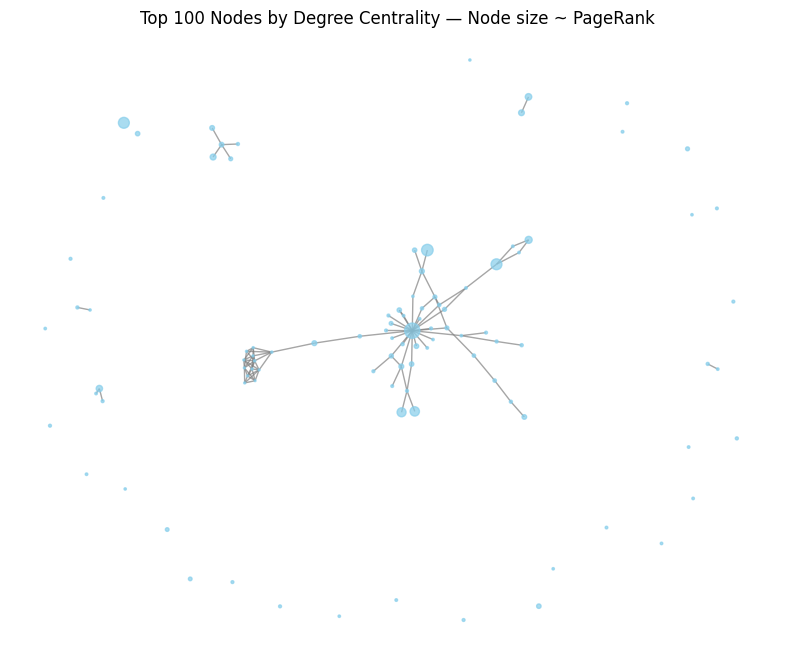

In [13]:
# --- Subgraph of Top 100 Nodes by Degree Centrality ---

# 1. Select top 100 nodes based on degree centrality
top_nodes = centrality_df.sort_values("degree_centrality", ascending=False).head(100)["txId"].tolist()

# 2. Extract subgraph
subG = G.subgraph(top_nodes)

# 3. Layout for visualization
pos = nx.spring_layout(subG, seed=42)

# 4. Node size scaled by PageRank (influence)
node_sizes = [pagerank_scores.get(n, 0) * 10000 for n in subG.nodes()]

# 5. Plot
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    subG,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color="skyblue",
    edge_color="gray",
    alpha=0.7
)
plt.title("Top 100 Nodes by Degree Centrality — Node size ~ PageRank")
plt.axis("off")
plt.show()


In [15]:
# 重新获取 top 100 节点（按 degree centrality 排名）
top_nodes = centrality_df.sort_values("degree_centrality", ascending=False).head(100)["txId"].tolist()

# 从原始图中提取子图
sample_subG = G.subgraph(top_nodes)


### Why We Visualize the Largest Connected Component?

While the top-degree nodes appeared structurally disconnected, the largest connected component (LCC) provides a much more meaningful snapshot of the actual transaction network.

The LCC contains all nodes that are reachable from one another, making it a suitable candidate for:

- Fraud detection using graph-based models
- Community detection or role inference
- Graph Neural Networks (GNN) input preprocessing

Although the full graph may contain many isolated or irrelevant nodes, the LCC reflects the *core transaction structure* where laundering and propagation likely happen.

In fraud analytics, analyzing the LCC helps us focus on the *network backbone* — where the real action is.


### Merging Features + Labels
We merge transaction features, graph centrality scores, and fraud labels to build a dataset for modeling.

In [10]:
# Add txId column
features_df = features_df.copy()
features_df["txId"] = classes_df["txId"]

# Keep only nodes from the LCC
features_lcc = features_df[features_df["txId"].isin(centrality_df["txId"])].reset_index(drop=True)
classes_lcc  = classes_df[classes_df["txId"].isin(centrality_df["txId"])].reset_index(drop=True)

# Merge features + centrality
merged_df = features_lcc.merge(centrality_df, on="txId", how="left")
merged_df["class_raw"] = classes_lcc["class"]
merged_df["label_supervised"] = classes_lcc["class"].map(label_map)  # 0/1 or NaN

print("Merged shape (LCC):", merged_df.shape)
merged_df.head()


Merged shape (LCC): (7880, 172)


,0,1,2,3,4,5,6,7,8,9,...,162,163,164,165,166,txId,degree_centrality,pagerank,class_raw,label_supervised
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230425980,0.000254,0.000131,unknown,NaN
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,0.000254,0.000142,unknown,NaN
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,0.000381,0.000158,unknown,NaN
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,0.020434,0.006917,2,0.0
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,0.001269,0.000242,unknown,NaN


## Next Steps



In [11]:
print("Supervised subset in LCC:")
print(merged_df["label_supervised"].value_counts(dropna=True).to_dict())

print("\nNext step: Notebook 2 (Preprocessing) will handle feature deduplication, temporal splits, and scaling.")


Supervised subset in LCC:
{0.0: 2130, 1.0: 17}

Next step: Notebook 2 (Preprocessing) will handle feature deduplication, temporal splits, and scaling.
